# Deterministic Model

Consider the following problem. One must make a selection of items $j \in J = \{1,\dots,n\}$ to compose a shipment of maximum value. Each item has an individual value of $c_j$, $j \in J$, and an individual weight $a_j$. The total shipment weight cannot exceed $K$. 

This problem can be formulated as follows. Let $x_j$, $j \in J$, be the fraction of item $j$ included in the shipment. Then, solving
\begin{align}
\max_x & \sum_j{c_j x_j} \label{E3:objective}\\
\text{s.t.: } & \sum_j{a_j}x_j \leq K \label{E3:const1} \\
    & 0 \leq x_j \leq 1, \forall j \in J  \label{E3:const2}
\end{align}

One can obtain an optimal shipment.


In [1]:
using JuMP, Cbc, Distributions, Random

## Setting initial data for weight a value c

number_of_items = 50
K = 500 
a = [23.1677; 38.5411; 20.7857; 91.2639; 88.8531; 59.0021; 46.8458; 87.3085; 90.2029; 84.7892; 93.654; 80.5882; 77.2142; 61.1733; 95.2264; 70.4182; 62.9188; 58.2519; 28.6744; 12.1574; 38.8476; 73.4748; 75.6089; 26.9231; 13.0826; 68.9559; 43.7193; 20.9045; 11.5951; 73.6138; 99.5393; 72.4457; 16.1868; 69.4912; 80.5066; 35.586; 88.0705; 76.0882; 12.6545; 52.421; 66.697; 95.7174; 18.6815; 66.9619; 13.4973; 29.8649; 46.4196; 78.6803; 16.4566; 71.329]
c = [111.425; 75.8917; 148.793; 99.3532; 180.952; 149.681; 140.894; 36.6643; 193.925; 15.198; 116.553; 34.165; 76.5255; 144.129; 89.4986; 105.582; 120.906; 173.364; 102.396; 111.247; 187.043; 61.9536; 155.218; 113.75; 81.4382; 196.099; 164.232; 127.833; 122.11; 94.9773; 159.716; 36.2398; 164.801; 122.474; 153.256; 20.0253; 97.1981; 72.6271; 80.9235; 38.7044; 149.701; 195.98; 48.4235; 66.7923; 78.5756; 128.656; 28.6767; 56.789; 100.574; 156.582]

## Creating the problem instance
deterministic_model = Model(with_optimizer(Cbc.Optimizer,logLevel = 0))

## Declaring x variables
@variable(deterministic_model, 0 <= x[1:number_of_items] <=1)

## Including objective function
@objective(deterministic_model, Max, sum(c .* x))

## Including constraint
@constraint(deterministic_model, sum(a .* x) <= K)

## Solve the model
optimize!(deterministic_model)

## Printing out the solution
x_value = value.(x)
print("Optimal selection: $(x_value),\nOptimal objective: $(objective_value(deterministic_model))\n")


Optimal selection: [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.962714, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0],
Optimal objective: 2326.8425233586972


Suppose that the weights $a_j$ follow a Gaussian distribution with average $\overline{a}_j$ and deviation $0.5\overline{a}$. What happens if we simulate that selection? In other words, what are the chances that we end up having a total shipment weight that is actually exceeds the weight limit $K$? Using Monte Carlo simulation, we observe the following.

In [2]:
Random.seed!(0)
number_of_simulations = 10000
results_of_simulations = []

for s in 1:number_of_simulations
    a_simulated = [rand(Normal(a[j], 0.5*a[j]),1)[1] for j in 1:length(a)] #sampling 10000 elements for the current simulation
    append!(results_of_simulations, (sum(a_simulated .* x_value) <= K) ? 1 : 0) #writing 1 to the resuting array if the constraint is still feasible and 0 if not 
end

print("Chance of feasibility.: $(sum(results_of_simulations)*100/number_of_simulations) %\n")    


Chance of feasibility.: 49.45 %


# Robust Model

Using the RO philosophy, let's assume that the weights vector $a$ is uncertain and take values in an interval which is defined as $e = \{\overline{a}  + Pu: {||u||}_2 \leq {\Gamma}_j \}$. Let us set $\overline{a} = a$ defined in determnistic example and $P = 0.1\overline{a}$. It lead us to following Robust Counterpart

\begin{align}
\max_x &\sum_j c_jx_j \\
\text{s.t.: } &\sum_j \left( a_jx_j \right) + \Gamma { \left( \sum_i { \left( [0.1a_i]x_i \right) }^2 \right) }^{1/2}  \leq K \\
& 0 \leq x_j \leq 1, \forall j \in J \\
\end{align}

which, once again, can be modelled as follows (note that we have embedded the model into a function so we can use in the following experiment).

## (a)

The new robust constraint can be derived as follows. Given the uncertainty set $\epsilon = \{\overline{a}  + Pu: {\|u\|}_2 \leq {\Gamma}_j \}$ where we'll denote $Pu=[\beta a_j u_j]_{j\in J}$ we have

$$
\begin{aligned}
\max_{\tilde{a}_j\in \epsilon} \sum_j \tilde{a}_j x_j 
&= \max_u \sum_j(a_j + u_j \beta a_j) x_j \\
&= \sum_j a_j x_j + \max_u \sum_j u_j \beta a_j x_j.
\end{aligned}
$$

We can write $\sum_j u_j \beta a_j x_j$ using dot product and rewrite the dot product using norms
$$
u \cdot [\beta a_j x_j]_j = \|u\| \|[\beta a_j x_j]_j\| \cos \theta.
$$
Now deriving the maximum is simple
$$
\Gamma \|[\beta a_j x_j]_j\| = \Gamma { \left( \sum_i { \left( [\beta a_i]x_i \right) }^2 \right) }^{1/2}.
$$
Now we have
$$
\max_{\tilde{a}_j\in \epsilon} \sum_j \tilde{a}_j x_j = \sum_j a_j x_j + \Gamma { \left( \sum_i { \left( [\beta a_i]x_i \right) }^2 \right) }^{1/2}.
$$

## (b)

In [10]:
using Ipopt

## TODO: Write here your student number as a string, for example, student_number = "112233"
student_number = 452056  #write your code here

# defining it for the robust formulation
P = 0.1*a
Gamma = 9

## TODO: Complete the code for the function that creates the problem instance, optimise it and 
## returns optimal selection of the items and the objective function value
function solve_robust_model(number_of_items, c, a, P, Gamma)
    
    #Creating the problem instance
    robust_model = Model(with_optimizer(Ipopt.Optimizer, print_level=0))

    # TODO: Declaring our x variables
    @variable(robust_model, 0 <= x[1:number_of_items] <=1)

    # TODO: Including OF
    @objective(robust_model, Max, sum(c .* x))

    # TODO: Including constraint
    @NLconstraint(robust_model, 
        sum(a[j] * x[j] for j in 1:number_of_items) + 
        Gamma * sum(((P[j] * x[j])^2 for j in 1:number_of_items))^(1/2) <= K)

    #Solve the model
    optimize!(robust_model)
    
    return value.(x), objective_value(robust_model)
end

## TODO: complete the code for the function that generates simulations and returns  
##       feasibility probability estimates 

function feasibility_estimate(number_of_simulations, solution)
    Random.seed!(0)
    results_of_simulations = []

    for s in 1:number_of_simulations
        ## sampling 10000 elements for the current simulation
        a_simulated = [rand(Normal(a[j], 0.5*a[j]),1)[1] for j in 1:length(a)] 
        
        observed_total_weight = sum(a_simulated .* solution) #write your code here)
        
        #writing 1 to the resulting array if the solution is feasible and 0 if not  
        append!(results_of_simulations, (observed_total_weight <= K) ? 1 : 0) 
    end
    return sum(results_of_simulations)*100/number_of_simulations
end   

## TODO: Write your student number after the letter 'f', so the name of the function 
##       will look like, for example, function f112233(number_of_items, c, a, P, Gamma, number_of_simulations)        

function f452056(number_of_items, c, a, P, Gamma, number_of_simulations)# write your code here
    
    robust_optimisation_results = solve_robust_model(number_of_items, c, a, P, Gamma)
    
    ## Printing out the solution for current model
    print("Optimal selection: $(robust_optimisation_results[1]),\nOptimal objective: $(robust_optimisation_results[2])\n")
    
    feasibility = feasibility_estimate(number_of_simulations, robust_optimisation_results[1])
    
    ## Printing out the feasibility estimation the current model
    print("Chance of feasibility.: $(feasibility)) %\n")
    
    return robust_optimisation_results, feasibility
end

#Verification of your code
           
## TODO: Write your student number after the letter 'f', so the call of the function 
##       will look like, for example, f112233(number_of_items, c, a, P, Gamma, number_of_simulations)

f452056(number_of_items, c, a, P, Gamma, number_of_simulations);  #write your code here
            
#For P = 0.1a and Gamma = 9 the results should be the following
#Optimal selection: [1.0, 0.0, 1.0, 0.0, 0.0, 0.0731138, 0.555431, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.421737, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.267819, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.367115, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0],
#Optimal objective: 2056.407855630069
#Chance of feasibility:  96.26% 

Optimal selection: [1.0, 0.0, 1.0, 0.0, 0.0, 0.0731138, 0.555431, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.421737, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.267819, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.367115, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0],
Optimal objective: 2056.407855630069
Chance of feasibility.: 96.26) %


## (c)

Let's do a similar experiment, but now using different values of $\Gamma$ to see what happens as we increase it. 


$\Gamma = 0$

In [11]:
f452056(number_of_items, c, a, P, 0, number_of_simulations);

Optimal selection: [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.962714, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0],
Optimal objective: 2326.842566694773
Chance of feasibility.: 49.45) %


$\Gamma = 1$

In [12]:
f452056(number_of_items, c, a, P, 1, number_of_simulations);

Optimal selection: [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.773484, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0],
Optimal objective: 2289.734744994186
Chance of feasibility.: 57.34) %


As we increase the value of $\Gamma$ from $0$ to $1$, the optimal objective decreases and chance of feasibility, that is, robustness, increases.

The increase in value of $\Gamma$ means that when more items $x_j$ are included the estimated maximum total shipment weight will increase more, filling the capacity $K$ faster, and therefore less items will be included. 

## (d)

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1186


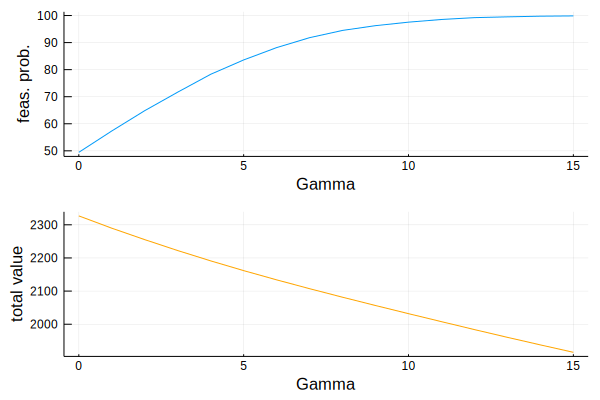

In [4]:
using Plots
## generate a range of Gammas to try
Gamma_max = 15 
Gammas = collect(0:Gamma_max)

## storing the results of each run
feas = Array{Float64}(undef, 0)
total_value = Array{Float64}(undef, 0)

## for each Gamma, solve te model and store the results
for Gamma in Gammas
    robust_optimisation_results = solve_robust_model(number_of_items, c, a, P, Gamma) 
    append!(total_value, robust_optimisation_results[2])
    append!(feas, feasibility_estimate(number_of_simulations, robust_optimisation_results[1]))
end

## plotting the results from simulation
p1 = plot(Gammas, feas, xlabel = "Gamma", ylabel = "feas. prob.", legend=false)
p2 = plot(Gammas, total_value, xlabel = "Gamma", ylabel = "total value", legend=false, color=:orange)
plot(p1,p2, layout = (2,1))

As we increase the value of $\Gamma$ the feasibility probability increases but the total value decreases.

It is impossible to find value for $\Gamma$ such that the probability is $100\%$ because normal distribution can sample values upto infinity.